In [4]:
from sklearn.manifold import TSNE
from src.main import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D
from src.generate_graph import *

# Examples of graph repairing with OT

This notebook corresponds to the experiments reported in the supplementary of our paper published at AiStat 2021. 
We can generate four synthetic graphs (g1-g4) composed of 150 nodes each on the basis of the stochastic block model with different block parameters. We further assume that each node is associated with one value of sensitive attribute $S \in \{0, \cdots, K\}$. 

- g1 corresponds to a graph with two communities and a strong dependency between the community structure and the sensitive attribute $S$;
- g2 has the same community structure as g1, but with $S$ being independent of the structure; 
- g3 corresponds to a graph with two imbalanced communities dependent on $S$ and a stronger intra-connection in the smaller community; 
- g4 is a graph with three communities, two of them being dependent on $S$, and the third one being independent. 

## Generation of the graphs

In [51]:
# Define the graph that we want to try (g1, g2, g3 or g4)
method = 'partition'
sizes = [50, 50]
probs = [[0.1, 0.001], [0.001, 0.1]]
nb_classes = 'binary'

# Number of simulated graphs
trial = 1

# Display 
log = 'False'

# Algorithm used for the repair
algo = 'emd'

In [52]:
# Generate the graph and the associated node attribute s
g, s = get_graph_prot(sizes=sizes, probs=probs, number_class=nb_classes,
     choice=method)

# Compute the assortativity coefficient 
print('Assortativity coefficient on the original graph: %0.3f'% nx.attribute_assortativity_coefficient(g, 's'))

Assortativity coefficient on the original graph: 0.799


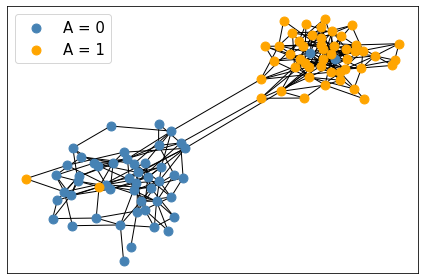

In [57]:
# Visualisation of the generated graph 

#Retrieve indexes of node in each group
s_idx = np.fromiter(s.values(), dtype=int)
prot0 = np.where(s_idx == 0)[0]
prot1 = np.where(s_idx == 1)[0]

# Draw the graph 
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos=pos, node_size=80, nodelist=prot0, node_color='steelblue', label='A = 0')
nx.draw_networkx_nodes(g, pos=pos, node_size=80, nodelist=prot1, node_color='orange', label='A = 1')
nx.draw_networkx_edges(g, pos=pos)
plt.legend(loc="upper left", scatterpoints=1, prop={'size': 15})
plt.tight_layout()
plt.savefig('high_ass.png', bbox_inches='tight')

In [55]:
plt.savefig('high_ass.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

## Repairing with OT (EMD version)

In [ ]:
print("Correcting the graph with EMD")

emd_adj, s_emd, gamma, M = total_repair_emd(g,  metric='euclidean', log=False)
# Build corrected graph from the corrected adjacency matrix
emd_g = nx.from_numpy_matrix(emd_adj)

# Filter out the smallest weights to keep a reasonable density
list_edge = [(u, v) for (u, v, d) in emd_g.edges(data=True) if d['weight'] < 0.5]
emd_g.remove_edges_from (list_edge)

# Coefficient of assortativity on the repaired graph
dict_s = {i: s_emd[i] for i in range(0, len(s_emd))}
nx.set_node_attributes(emd_g, dict_s, 's')
print('Assortativity coeffcient on the repaired (EMD) graph: %0.3f'
      % nx.attribute_assortativity_coefficient(emd_g, 's'))

## Impact on the embeddings

We are now ready to illustrate the impact of the repairing on the node embeddings. 
To proceed, we use Node2Vec as an example.

In [ ]:
# Learn node embeddings for both graphs
print("Start learning embedding on the original graph")
embedding_origin, s_origin, modelO = emb_node2vec(g, s_idx)

print("Start learning embedding on the repaired graph")
embedding_emd, s_emd, modelR = emb_node2vec(emd_g, s_idx)

In [ ]:
# Compute the Representation Bias

kfold = 5
clf = model_selection.KFold(n_splits=5, random_state=100, shuffle=True)
clf = LogisticRegression(solver='lbfgs')

results_origin = model_selection.cross_val_score(clf, embedding_origin, s_origin, cv=kfold,
                                                     scoring='roc_auc')

print("RB on the original graph is: %8.2f" % results_origin.mean())

results_emd = model_selection.cross_val_score(clf, embedding_emd, s_emd, cv=kfold,
                                                     scoring='roc_auc')

print("RB on the repaired graph is: %8.2f" % results_emd.mean())

In [ ]:
# Visualisation of the embeddings with TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y = tsne.fit_transform(embedding_origin)
Z = tsne.fit_transform(embedding_emd)
x1_coords = Y[:, 0]
y1_coords = Y[:, 1]

x2_coords = Z[:, 0]
y2_coords = Z[:, 1]

c = ['steelblue', 'gold']
k = 0
legend_elements = [Line2D([0], [0], marker='o', color='white', label='S = 0', markerfacecolor='steelblue', markersize=15),
        Line2D([0], [0], marker='o', color='white', label='S = 1',  markerfacecolor='gold', markersize=15),
      ]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for l in np.unique(s_origin):
    i = np.where(s_origin == l)
    ax[0].scatter(x1_coords[i], y1_coords[i], color=c[k], s=100)
    k += 1
k = 0
ax[0].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off',
                        labelleft='off')
for l in np.unique(s_emd):
    i = np.where(s_emd == l)
    ax[1].scatter(x2_coords[i], y2_coords[i], color=c[k], s=100)
    k += 1

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.1),
                  ncol=3, fancybox=True, shadow=False, prop={'size': 30}, fontsize=30)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off',
                         labelleft='off')
plt.tight_layout()
       
plt.show()

## Correction of the graph with the laplacian regularizer

In [ ]:
print("Correcting the graph with Laplacian regularizer")

r = 0.01
new_x_l, s, gamma, M = total_repair_reg(g, metric='euclidean', reg=r)
lap_g = nx.from_numpy_matrix(new_x_l)

# Filter out the smallest weights to keep a reasonable density
list_edge = [(u, v) for (u, v, d) in lap_g.edges(data=True) if d['weight'] < 0.5]
lap_g.remove_edges_from(list_edge)

In [ ]:
# Coefficient of assortativity
dict_s = {i: s[i] for i in range(0, len(s))}
nx.set_node_attributes(lap_g, dict_s, 's')
print('Assortativity coefficient on the repaired (Lap) graph: %0.3f'
      % nx.attribute_assortativity_coefficient(lap_g, 's'))  

In [ ]:
# Compute the embeddings
embedding_lap, s_lap, modelR = emb_node2vec(lap_g, s_idx)

In [ ]:
# Compute the Representation Bias

clf = model_selection.KFold(n_splits=5, random_state=100, shuffle=True)
clf = LogisticRegression(solver='lbfgs')

results_lap = model_selection.cross_val_score(clf, embedding_lap, s_lap, cv=kfold,
                                                     scoring='roc_auc')

print("RB on the repaired graph (Laplace version) is: %8.2f" % results_lap.mean())
print("RB on the repaired graph (EMD) is: %8.2f" % results_emd.mean())
print("RB on the original graph is: %8.2f" % results_origin.mean())